# Game of Life

[Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life), introduced by John H. Conway in 1970, is a 2D cellular automaton that simulates a world populated by cells.  The world is a 2D square grid that is, in principle, infinite.  Each grid position represents a cell that can be either alive, or dead.  The game is played over a number of generations.  To compute the next generation, each grid position is considered indepedently. The rules are straightforward:

* If a cell in generation $t$ is alive,
  * it is alive in generation $t + 1$ if it has either two or three life neighbours in generation $t$;
  * it is dead in generation $t + 1$ otherwise.
* If a cell in generation $t$ is dead,
  * it is alive in generatino $t + 1$ if it has exactly three neighbours in generation $t$;
  * it is dead in generation $t + 1$ otherwise.
  
Each cell has eight neighbours.  Typically, the Game of Life world is represented by an $n \times n$ array, and periodic boundary conditions are applied to simulate an infinite world.

## Required imports

In [15]:
from IPython.display import HTML
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import numpy as np

## World representation

A Game of Life world will be represented by an array of integers.  Each array element represents a cell that can either be dead (0) or alive (1).  First, we define a class that represents a world, and that is initialized from a given numpy array.  This will serve as a base class for classes that implement specific initializations.  Typically, those should override `__init__`.  The `World` base class defines all methods to compute the next generation, get information on the world's state, as well a string representation.

In [2]:
class World:
    '''Class representing a Game of Life world, intended to be subclassed
    for specific initialization strategies.'''
    
    def __init__(self, cells):
        '''Initialize a world using the cells provided
        
        Parameters
        ----------
        cells : np.ndarray
            2D numpy array representing the world, 1 represents a cell that
            is alive, 0 represents a dead cell.
        '''
        self._world = np.copy(cells.astype(np.int8))
        self._tmp_world = np.empty_like(self._world)
    
    @property
    def shape(self):
        '''Get the shape of the world
        
        Returns
        -------
        tuple
            shape of the world as a 2-tuple of int
        '''
        return self._world.shape
    
    @property
    def nr_alive(self):
        '''Get the number of cells that are alive
        
        Returns
        -------
        int
            number of cells alive in the world
        '''
        return np.sum(self._world)

    @property
    def cells(self):
        '''Get the world as a 2D numpy array
        
        Returns
        -------
        np.ndarray
            2D numpy array of 0 and 1 int values, where 1 represents
            a cell that is alive, and 0 one that is dead
        '''
        return np.copy(self._world)

    @property
    def fraction_alive(self):
        '''Get the fraction of cells that are alive in the world
        
        Returns
        -------
        float
            fraction of cells that are alive
        '''
        return np.sum(self._world)/(self.shape[0]*self.shape[1])
    
    def is_alive(self, i, j):
        return self._world[i, j] == 1
    
    def nr_neignbours(self, i, j):
        up = (i + self.shape[0] - 1) % self.shape[0]
        down = (i + 1) % self.shape[0]
        left = (j + self.shape[1] - 1) % self.shape[1]
        right = (j + 1) % self.shape[1]
        return (self._world[up, left] + self._world[up, j] +
                    self._world[up, right] +
                self._world[i, left] + self._world[i, right] +
                self._world[down, left] + self._world[down, j] +
                    self._world[down, right])
    
    def next_generation(self):
        '''Compute the world's next generation
        '''
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                nr_nb = self.nr_neignbours(i, j)
                if self.is_alive(i, j):
                    self._tmp_world[i, j] = 1 if nr_nb == 2 or nr_nb == 3 else 0
                else:
                    self._tmp_world[i, j] = 1 if nr_nb == 3 else 0
        self._world = self._tmp_world


        
    def __repr__(self):
        return '\n'.join(' '.join(f'{self._world[i, j]:1d}'
                                  for j in range(self.shape[1]))
                         for i in range(self.shape[0]))

### Random world

The `RandomWorld` class inherits from the `World` basse class, and initializes a world of $n \times n$ randomly, but where a fraction $f_{\rm alive}$ is alive.

In [3]:
class RandomWorld(World):
    '''Class representing a world that is initialized randomly so that a given
    fraction of cells is alive.  Note this is not necessarily exact.'''
    
    def __init__(self, n, f_alive):
        '''Create a random world with a give fraction of cells that are alive.
        
        Parameters
        ----------
        n : int
            size of the n*n world
        f_alive : float
            fraction of cells that are alive (between 0.0 and 1.0)
        '''
        super().__init__(np.random.choice(np.array([0, 1], dtype=np.int8),
                                          (n, n), p=(1 - f_alive, f_alive)))

Create a world and run a generation.

In [ ]:
world = RandomWorld(10, 0.4)
world

In [ ]:
world.next_generation()
print(world)

### Patch world

A second, interesting way to initialize a world is from a numpy array representing an $p_0 \times p_1$ patch in the $n \times n$ world, where, obviously, $p_0 \le n$ and $p_1 \le n$.

In [4]:
class PatchWorld(World):
    '''Class that is initialized with a patch given as a 2D numpy array. All
    other cells are dead.'''
    
    def __init__(self, n, patch):
        '''Create a random world with a give initial patch, all
        other cells will be dead.
        
        Parameters
        ----------
        n : int
            size of the n*n world
        patch : np.ndarray
            2D numpy array containing the part of the world to be
            initialized; patch.shape[0] <= n, patch.shape[1] <= n,
            and patch should contain 1 for a cell that is alive, 0
            for a cell that is dead
        '''
        world = np.zeros((n, n))
        world[0:patch.shape[0], 0:patch.shape[1]] = patch
        super().__init__(world)

In [ ]:
world = PatchWorld(10, np.array([[1, 0, 0], [1, 1, 0]]))
world

## Simulation runner

We define a class to conveniently perform a complete simulation.  At most `max_gen` generations are computed, but the computation stops as soon as a cycle is detected.

In [58]:
class WorldRunner:
    '''Class to run a simulation of the given world over a maximum of
    generations. The simulation will stop as soon as a cycle is detected.'''
    
    def __init__(self, world, max_gen, early_stopping=True):
        '''Initialize the run with the initial world and the maximum
        number of generations to simulate.
        
        Parameters
        ----------
        world : World
            initial world to run the simulation on
        max_gen : int
            maximum number of generations to simulate
        early_stopping : bool
            if True, stop when a cycle is detected, otherwise,
            continue form max_gen generations
        '''
        self._world = world
        self._max_gen = max_gen
        self._early_stopping = early_stopping
        self._cycle_length = None
        self._hist = [self._world.cells]
    
    @property
    def max_gen(self):
        '''Get the maximum generation for this simulation
        
        Returns
        -------
        int
            maximum number of generations for this run
        '''
        return self._max_gen

    @property
    def nr_generations(self):
        '''Get the number of generations computed, note that this may be less than
        the maximum number of generations if a cycle was detected.
        
        Returns
        -------
        int
            number of generations computed in this run
        '''
        return len(self._hist) - 1
    
    def has_cycle(self):
        '''Check whether a cycle was detected.
        
        Returns
        -------
        bool
            True if a cycle was detected, False otherwise
        '''
        return self._cycle_length is not None
    
    @property
    def cycle_length(self):
        '''Get the cycle length, if any.
        
        Returns
        -------
        int
            length of the detected cycle, None if no cycle was found.
        '''
        return self._cycle_length
    
    @property
    def history(self):
        '''Get the world history.
        
        Returns
        -------
        list
            a list of the generations of this world, represented as 2D
            numpy arrays.
        '''
        return self._hist
    
    def _has_cycle(self):
        for gen in range(-2, -len(self._hist), -1):
            if np.all(self._hist[-1] == self._hist[gen]):
                self._cycle_length = -gen - 1
                return True
        return False
    
    def run(self):
        '''Run the simulation for the world.
        '''
        for _ in range(1, self.max_gen + 1):
            self._world.next_generation()
            self._hist.append(self._world.cells)
            if self._has_cycle() and self._early_stopping:
                break

Create a world, and run it for a number of generations, then check on the properties.

In [ ]:
world = RandomWorld(10, 0.3)
runner = WorldRunner(world, 100)
runner.run()

The current state of the world can be checked.

In [ ]:
world

In [ ]:
world.fraction_alive

Check whether a cycle has been detected, what the cycle length is, and after how many generations it occured.

In [ ]:
runner.has_cycle()

In [ ]:
runner.cycle_length

In [ ]:
runner.nr_generations

## Simulation visualization

To gain insight in the Game of Life dynamics, it is useful to visualize the consecutive generations of a world.  This can be done by using the `FuncAnimation` function provided by matplotlib.  Given the setup for this function, it is convenient to wrap its creation in a class.

In [6]:
class WorldView:
    '''Class for creating an animation of the world's history.'''
    
    def __init__(self, world_runner):
        '''Initialize the view object.
        
        Parameters
        ----------
        world_runner : WorldRunner
            runner that has completed a simulation to visualize.
        '''
        self._world_runner = world_runner
        self._nr_gen = world_runner.nr_generations
        self._figure, self._axes = plt.subplots()
        self._axes.get_xaxis().set_visible(False)
        self._axes.get_yaxis().set_visible(False)
    
    @property
    def figure(self):
        return self._figure

    def create_animation(self):
        '''Create an animation.
        
        Returns
        -------
        function
            function that will visualize the simulation.
        '''
        return FuncAnimation(self.figure, self.create_animate(),
                             init_func=self.create_init(),
                             frames=self._world_runner.nr_generations)
        
    def create_animate(self):
        def animate(i):
            self._axes.imshow(self._world_runner.history[i])
        return animate

    def create_init(self):
        def init():
            self._axes.imshow(self._world_runner.history[0])
        return init

In [ ]:
world_size = 10
f_alive = 0.3
max_generations = 100
world = RandomWorld(world_size, f_alive)
world_runner = WorldRunner(world, max_generations)
world_runner.run()

In [ ]:
world_runner.nr_generations

In [ ]:
world_view = WorldView(world_runner)
animation = world_view.create_animation()

HTML(animation.to_jshtml(default_mode='once'))

In [ ]:
world

In [ ]:
world_runner.cycle_length

## Simulation statistics

First, we define a class that is an iterator over randomlly initialized worlds.  All worlds will have the same given size, and fraction of cells that are alive.

In [40]:
class RandomWorldGenerator:
    '''Iterator over randomly initialized worlds.'''
    
    def __init__(self, nr_worlds, size, f_alive):
        '''Create an iterator over a given number of worlds, each of the same
        size, and (approximately) the same number of cells that are alive.
        
        Parameters
        ---------
        nr_worlds : int
            number of worlds to generate
        size : int
            world size
        f_alive : float
            fractino of cells that are alive
        '''
        self._nr_worlds = nr_worlds
        self._size = size
        self._f_alive = f_alive
    
    def __iter__(self):
        self._current = 0
        return self
    
    def __next__(self):
        if self._current < self._nr_worlds:
            self._current += 1
            return RandomWorld(self._size, self._f_alive)
        else:
            raise StopIteration

In [41]:
for world in RandomWorldGenerator(3, 5, 0.3):
    print(world, end='\n\n')

0 0 1 0 0
0 0 0 0 0
1 0 1 0 0
0 0 0 1 0
0 1 0 0 0

0 0 0 0 1
0 0 0 0 1
0 0 0 0 0
1 0 0 0 0
1 1 0 0 1

1 1 0 0 1
1 1 0 0 1
1 1 0 1 0
0 0 0 0 0
0 0 0 1 0



Next, we define a class to perform a number of simulation, and gather statistics on the number of cells that are alive for each generation.

In [59]:
def compute_avg_live_cels(world_generator, max_gen):
    nr_alive = np.zeros(max_gen + 1)
    nr_worlds = 0
    for world in world_generator:
        nr_worlds += 1
        world_runner = WorldRunner(world, max_gen, early_stopping=False)
        world_runner.run()
        for i, generation in enumerate(world_runner.history):
            nr_alive[i] += np.sum(generation)
    return nr_alive/(nr_worlds*generation.shape[0]*generation.shape[1])

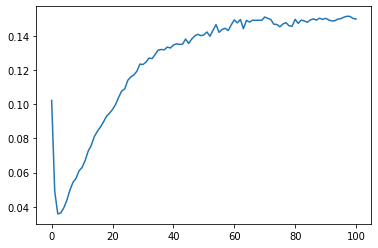

In [68]:
nr_generations = 100
stats = compute_avg_live_cels(RandomWorldGenerator(nr_worlds=50, size=20, f_alive=0.1), max_gen=nr_generations)
_ = plt.plot(range(nr_generations + 1), stats)

A second experiment would be to check how many initial world configurations of $p \times p$ where $p \le n$ and $n$ is the size of the world.  For a $p \times p$ patch, there are $2^{p^2}$ initial configurations.

In [10]:
class PatchGenerator:
    '''Iterator class for all worlds that are initialized from all compbinations of cells
    are alive or dead in an p by p patch, while all other cells are dead.  The number of
    such worlds is 2^(p*p)'''
    
    def __init__(self, size, patch_size):
        '''Initialize the iterator fow a given patch size on a given board size
        
        Parameters
        ----------
        size : int
            size of the world
        patch_size : int
            size of the patch, should be less than or equal to size
        '''
        if size < patch_size:
            raise ValueError('patch size should be less or equal to world size')
        self._size = size
        self._patch_size = patch_size
        self._patch_idx = None
    
    def __iter__(self):
        self._patch_idx = 0
        return self
    
    def _create_patch(self):
        patch = np.empty((self._patch_size, self._patch_size))
        for i in range(self._patch_size):
            for j in range(self._patch_size):
                patch[i, j] = 1 if self._patch_idx & (1 << (i*self._patch_size + j)) else 0
        return patch
    
    def __next__(self):
        if self._patch_idx >= 2**(self._patch_size**2):
            raise StopIteration
        world = PatchWorld(self._size, self._create_patch())
        self._patch_idx += 1
        return world

In [13]:
patch_generrator = PatchGenerator(3, 2)
for world in patch_generrator:
    print(world, end='\n\n')

0 0 0
0 0 0
0 0 0

1 0 0
0 0 0
0 0 0

0 1 0
0 0 0
0 0 0

1 1 0
0 0 0
0 0 0

0 0 0
1 0 0
0 0 0

1 0 0
1 0 0
0 0 0

0 1 0
1 0 0
0 0 0

1 1 0
1 0 0
0 0 0

0 0 0
0 1 0
0 0 0

1 0 0
0 1 0
0 0 0

0 1 0
0 1 0
0 0 0

1 1 0
0 1 0
0 0 0

0 0 0
1 1 0
0 0 0

1 0 0
1 1 0
0 0 0

0 1 0
1 1 0
0 0 0

1 1 0
1 1 0
0 0 0



In [24]:
def compute_cycle_count(world_generator, max_gen):
    '''Function to cmopute statistics on the number of worlds that lead
    to cycles of various lengths
    
    Parameters
    ----------
    world_generator : iterator
        Iterator that returns initialized words
    max_gen : int
        Maximum number of generation to simulate per word
        
    Returns
    -------
    collections.Counter
        count for each cycle length, for the number of words that
        contain only dead cells and for worlds for which no cycle
        was detected.
    '''
    cycle_count = Counter()
    nr_worlds = 0
    for world in self._world_gen:
        nr_worlds += 1
        world_runner = WorldRunner(world, self._max_gen)
        world_runner.run()
        if world.nr_alive > 0:
            if world_runner.has_cycle():
                cycle_count[world_runner.cycle_length] += 1
            else:
                cycle_count['no cycle'] += 1
        else:
            cycle_count['dead'] += 1
    return self._cycle_count

In [20]:
cycle_stats = CycleStatistics(PatchGenerator(5, 2), 10)
cycle_stats.compute()
cycle_count = cycle_stats.cycle_count()
for cycle_length in cycle_count:
    print(f'{cycle_length}: {cycle_count[cycle_length]}')

dead: 11
1: 5
